In [1]:
import os
import glob
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load data from csv-files
The used data can be found [here](https://github.com/rc9000/wiewarm-data) and is free to use according to Creatvie Commons Attribution-ShareAlike 3.0. 

In [2]:
os.chdir("./data/raw")

In [3]:
extension = 'csv'
filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [4]:
filenames

['wiewarm-2010.csv',
 'wiewarm-2011.csv',
 'wiewarm-2012.csv',
 'wiewarm-2013.csv',
 'wiewarm-2014.csv',
 'wiewarm-2015.csv',
 'wiewarm-2016.csv',
 'wiewarm-2017.csv',
 'wiewarm-2018.csv',
 'wiewarm-2019.csv',
 'wiewarm-2020.csv']

In [5]:
df = pd.concat([pd.read_csv(f, sep=';') for f in filenames])

## Data exploration
Following steps are done during this exploration and manipulation:
* Dropping unneseccary columns
* Manual outlier detection (could be done with ML)
* Grouping the temperatures per day
* Creating a time series and some analysing plots

In [6]:
df.head()

,datum,badid,bad,adresse1,adresse2,ort,plz,kanton,beckenid,becken,typ,temperatur
0,2010-01-01 00:05:00,7,Badebetriebe Thun,Strandbad Thun,Strandbadweg 10,Thun,3604.0,BE,22,Strandbad Thun (50m),Freibad,4.4
1,2010-01-01 00:05:00,7,Badebetriebe Thun,Strandbad Thun,Strandbadweg 10,Thun,3604.0,BE,23,Strandbad Thun (See),See,5.6
2,2010-01-01 00:10:00,125,Inn,NaN,NaN,S-chanf,7525.0,GR,289,Inn,Fluss,1.5
3,2010-01-01 00:10:00,50,Rhein,NaN,NaN,Rheinfelden,4310.0,AG,135,Rhein,Fluss,7.1
4,2010-01-01 00:15:00,8,Arbeiterstrandbad,Arbeiterstrandbad Tennwil,Strandbadweg 1,Tennwil,5617.0,AG,28,Hallwilersee,See,5.2


In [7]:
df.shape

(1736769, 12)

In [8]:
# gapminder_2002 = gapminder[gapminder['year']==2002]
df = df[df['beckenid'] == 52]

In [9]:
df.head()

,datum,badid,bad,adresse1,adresse2,ort,plz,kanton,beckenid,becken,typ,temperatur
16,2010-01-01 00:50:00,17,Stadt Bern,NaN,NaN,Bern,3000.0,BE,52,Aare Marzili,Fluss,6.5
50,2010-01-01 03:00:00,17,Stadt Bern,NaN,NaN,Bern,3000.0,BE,52,Aare Marzili,Fluss,6.4
84,2010-01-01 05:00:00,17,Stadt Bern,NaN,NaN,Bern,3000.0,BE,52,Aare Marzili,Fluss,6.3
118,2010-01-01 07:00:00,17,Stadt Bern,NaN,NaN,Bern,3000.0,BE,52,Aare Marzili,Fluss,6.2
154,2010-01-01 09:00:00,17,Stadt Bern,NaN,NaN,Bern,3000.0,BE,52,Aare Marzili,Fluss,6.3


In [10]:
df.shape

(78960, 12)

In [11]:
unused_cols = ['badid', 'bad', 'adresse1', 'adresse2', 'ort', 'plz', 'kanton', 'beckenid', 'becken', 'typ']
df =  df.drop(unused_cols, axis=1)

In [12]:
df['datum'] = pd.to_datetime(df['datum'])
df['datum'] = df['datum'].dt.date

In [13]:
# Filter unrealistic temperatures (Manual outliers detection)
df.drop(df[(df.temperatur > 30) | (df.temperatur < 5)].index, inplace=True)

In [14]:
df.head()

,datum,temperatur
16,2010-01-01,6.5
50,2010-01-01,6.4
84,2010-01-01,6.3
118,2010-01-01,6.2
154,2010-01-01,6.3


In [15]:
ts = df.groupby('datum')['temperatur'].mean().rename('Aare-temperature')

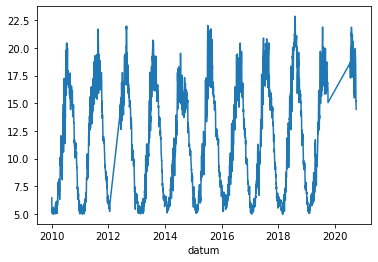

In [16]:
ts.plot()

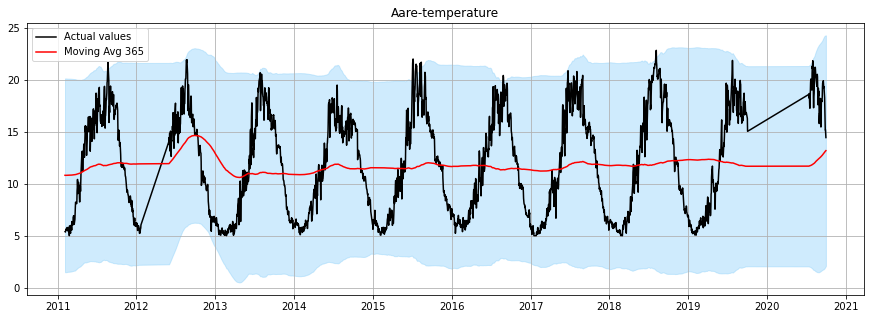

In [31]:
window = 365

rolling_mean = ts.rolling(window=window).mean()
rolling_std = ts.rolling(window=window).std()
plt.figure(figsize=(15,5))
plt.title(ts.name)
plt.plot(ts[window:], label='Actual values', color='black')
plt.plot(rolling_mean, 'g', label='Moving Avg '+str(window), color='red')
lower_bound = rolling_mean - (2 * rolling_std)
upper_bound = rolling_mean + (2 * rolling_std)
plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound, color='lightskyblue', alpha=0.4)
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Modeling
### Preparing data
The predictions of the value at a certain date are made based on n-time steps before the certain date. For this window implementation the method create_dataset is used. To prevent our model from overfitting we split our data in 80% train and 20% test data. The sequence of the data is static and should not randomized. 

In [19]:
df = df.groupby('datum').mean()

In [20]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(len(train), len(test))

2752 689


In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [22]:
time_steps = 10

X_train, y_train = create_dataset(train, train, time_steps)
X_test, y_test = create_dataset(test, test, time_steps)

print(X_train.shape, y_train.shape)

(2742, 10, 1) (2742, 1)


### Creating the model

In [25]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

In [26]:
learner = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Epoch 1/30
155/155 [==============================] - 1s 9ms/step - loss: 26.8950 - val_loss: 8.2210
Epoch 2/30
155/155 [==============================] - 1s 6ms/step - loss: 3.6985 - val_loss: 2.1799
Epoch 3/30
155/155 [==============================] - 1s 6ms/step - loss: 1.6166 - val_loss: 1.6350
Epoch 4/30
155/155 [==============================] - 1s 6ms/step - loss: 1.2309 - val_loss: 1.4980
Epoch 5/30
155/155 [==============================] - 1s 6ms/step - loss: 1.0323 - val_loss: 1.3773
Epoch 6/30
155/155 [==============================] - 1s 6ms/step - loss: 0.9466 - val_loss: 1.2667
Epoch 7/30
155/155 [==============================] - 1s 6ms/step - loss: 0.8984 - val_loss: 1.1702
Epoch 8/30
155/155 [==============================] - 1s 6ms/step - loss: 0.8651 - val_loss: 1.0818
Epoch 9/30
155/155 [==============================] - 1s 6ms/step - loss: 0.8351 - val_loss: 1.0307
Epoch 10/30
155/155 [==============================] - 1s 5ms/step - loss: 0.8063 - val_loss: 0.959

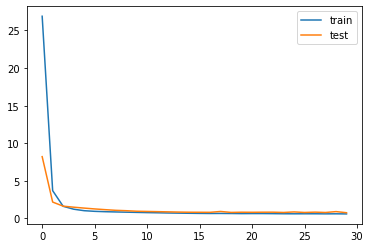

In [27]:
plt.plot(learner.history['loss'], label='train')
plt.plot(learner.history['val_loss'], label='test')
plt.legend();

In [28]:
y_pred = model.predict(X_test)

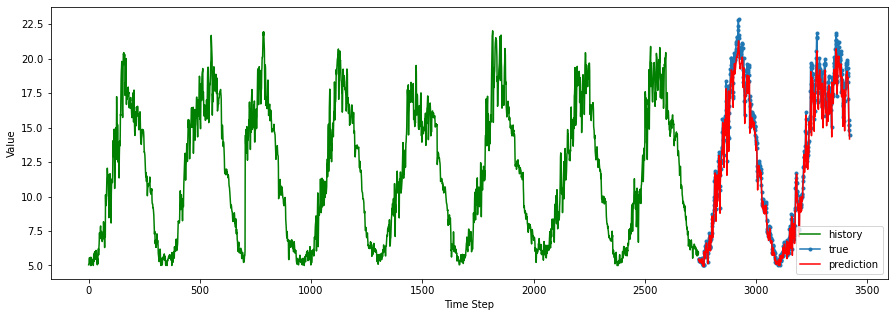

In [37]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, len(y_train)), y_train, color='green', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, color='red', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

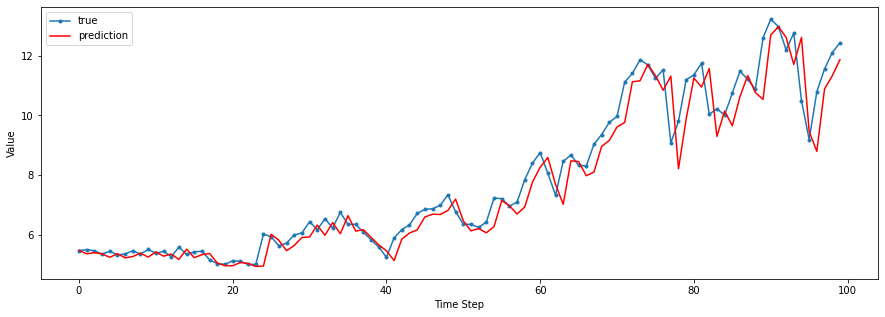

In [42]:
plt.figure(figsize=(15,5))
plt.plot(y_test[:100], marker='.', label="true")
plt.plot(y_pred[:100], color='red', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();